<a href="https://colab.research.google.com/github/crislpzalc/VISAMarketTrendForecast/blob/main/VISA_market_trend_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download the Data

Download the VISA Stock Data 2024 from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("umerhaddii/visa-stock-data-2024")

print("Path to dataset files:", path)

100%|██████████| 112k/112k [00:00<00:00, 21.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/umerhaddii/visa-stock-data-2024/versions/1


Find the dataset

In [2]:
import pandas as pd
import os

# Find the csv file in the path downloaded before
for file in os.listdir(path):
  if file.endswith(".csv"):
    csv_file = os.path.join(path, file)
    break

# Convert the dataset in DataFrame
df = pd.read_csv(csv_file)

# Looking at the Data

In [3]:
# show the first five rows
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-03-19,14.875000,17.250000,13.7500,14.1250,12.579995,708486000
1,2008-03-20,14.600000,16.250000,14.3750,16.0875,14.327834,198985200
2,2008-03-24,16.809999,16.924999,14.7500,14.9325,13.299167,149566400
3,2008-03-25,15.145000,16.062500,14.9550,15.8125,14.082910,87092000
4,2008-03-26,15.682500,16.120001,15.3925,15.9900,14.240999,43111600


In [4]:
# show basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4177 non-null   object 
 1   Open       4177 non-null   float64
 2   High       4177 non-null   float64
 3   Low        4177 non-null   float64
 4   Close      4177 non-null   float64
 5   Adj Close  4177 non-null   float64
 6   Volume     4177 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 228.6+ KB


In [5]:
# show statistical info about each column
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4.177000e+03
mean,109.997006,110.988504,108.997184,110.016274,106.440847,1.459021e+07
std,84.678218,85.385175,83.960169,84.686806,84.244500,1.967747e+07
min,10.672500,11.047500,10.445000,10.605000,9.477159,1.640900e+06
25%,29.635000,29.934999,29.347500,29.737499,27.196886,6.622700e+06
50%,78.980003,79.650002,78.379997,79.040001,74.487785,9.420400e+06
75%,196.250000,198.830002,193.809998,196.160004,190.993469,1.538160e+07
max,291.839996,293.070007,290.079987,291.559998,291.559998,7.084860e+08


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

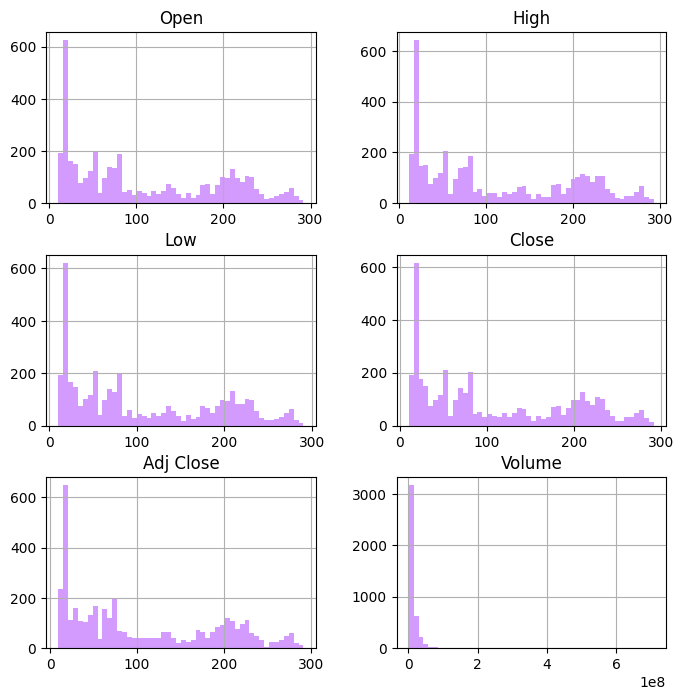

In [6]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(8,8), color="#D29BFD")

# Create Test Set


Using sklearn to create the test set

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# Explore the Data

Set aside the Test Set and explore the data of the Train Set

In [8]:
# copy of the train set to explore it
train_copy = train_set.copy()

In [9]:
# correlations between the attributes and the volume
corr_matrix = train_copy.corr(numeric_only=True)
corr_matrix["Volume"].sort_values(ascending=False)

,Volume
Volume,1.000000
Adj Close,-0.351275
High,-0.353551
Open,-0.355018
Close,-0.355225
Low,-0.356504


As it is shown, there is a moderate negative correlation between the volume of transactions and the prices. We the volume is high the prices tend to lower a little bit.

In [10]:
corr_matrix["Close"].sort_values(ascending=False)

,Close
Close,1.000000
Low,0.999909
High,0.999898
Adj Close,0.999830
Open,0.999808
Volume,-0.355225


As it is shown, there is a pretty high correlation between the close price and th rest of prices. We can consider deleting some of them of creating new variables.

In [11]:
# create some new variables and eliminate others
train_copy["High-Low"] = train_copy["High"] - train_copy["Low"]
train_copy["Close-Open"] = train_copy["Close"] - train_copy["Open"]
train_copy = train_copy.drop(columns=["Low", "High", "Adj Close", "Open", "Date"])

# we have to do the same with the test set
test_copy = test_set.copy()
test_copy["High-Low"] = test_copy["High"] - test_copy["Low"]
test_copy["Close-Open"] = test_copy["Close"] - test_copy["Open"]
test_copy = test_copy.drop(columns=["Low", "High", "Adj Close", "Open", "Date"])

corr_matrix = train_copy.corr(numeric_only=True)
corr_matrix["Volume"].sort_values(ascending=False)

,Volume
Volume,1.000000
Close-Open,-0.011718
High-Low,-0.128445
Close,-0.355225


As it is shown, the new variables doesn't have to much correlation with the Volume, but it can give us some information of the trend of the market. Let's make a trend variable.

In [12]:
# binary variable
train_copy["Trend"] = (train_copy["Close"].shift(-1) > train_copy["Close"]).astype(int)

# we have to do the same for test_set
test_copy["Trend"] = (test_copy["Close"].shift(-1) > test_copy["Close"]).astype(int)

In [13]:
corr_matrix = train_copy.corr(numeric_only=True)
corr_matrix["Trend"].sort_values(ascending=False)

,Trend
Trend,1.000000
Volume,0.249924
Close-Open,-0.001598
High-Low,-0.379033
Close,-0.548675


As it is shown, the variable Close-Open doesn't provide information to predist the trend. We can choose to eliminate it.
Regarding the volume, there is a low positive correlation, so when the volume of the day increases there's a weak tendency of increasing the prices next day.
For the variables High-Low and Close there's a moderate negative correlation. When the volatility of the day or the closed price are high, there is a tendency of decresing the prices of the next day.

In [14]:
train_copy = train_copy.drop(columns=["Close-Open"])

# Prepare the data

We separate the X's and the y

In [15]:
y_train = train_copy["Trend"].copy()
train_copy = train_copy.drop("Trend", axis=1)

# we do the same for test set
y_test = test_copy["Trend"].copy()
test_copy = test_copy.drop("Trend", axis=1)

Create a pipeline to preprocess the data to add missing data and make a logaritmic transformation

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# to add missing data
imputer = SimpleImputer(strategy="median")

# to transform the data
log_transformer = FunctionTransformer(np.log, feature_names_out="one-to-one")

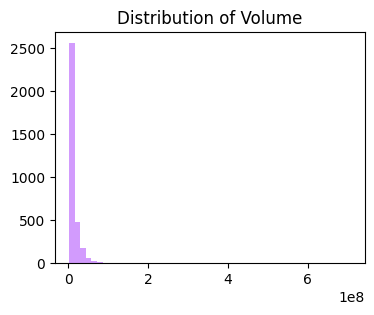

In [17]:
# see if there is a bias
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.hist(train_copy['Volume'], bins=50, color="#D29BFD")
plt.title("Distribution of Volume")
plt.show()


As is it shown, most of the data are concentrated near 0, the data is skewed. Let's prove it.

In [18]:
# calculate the skewness for all the numeric columns
skewness = train_copy.skew(numeric_only=True)
print(skewness)

Close        0.451519
Volume      16.371336
High-Low     2.078039
dtype: float64


Let's apply the logaritmic transform in the skewnessed variables. We use a pipeline to simplify the process.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

preprocessing = ColumnTransformer([("log_transform", Pipeline([
    ("imputer", imputer), ("log", log_transformer)]), ["Volume", "High-Low"]),
                                   ("imputer_only", imputer, ["Close"])
                                   ], remainder='passthrough')

Let's apply it

In [20]:
train_copy_prepared = preprocessing.fit_transform(train_copy)
train_copy_prepared.shape

(3341, 3)

In [21]:
preprocessing.get_feature_names_out()

array(['log_transform__Volume', 'log_transform__High-Low',
       'imputer_only__Close'], dtype=object)

# Select the model

Starting with Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(train_copy, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>))]),
                                                  ['Volume', 'High-Low']),
                                                 ('imputer_only',
                                                  SimpleImputer(strategy='median'),
                                                  ['Close'])])),
                ('linearregression', LinearRegression())])

In [23]:
>>> trend_predictions = lin_reg.predict(train_copy)
>>> trend_predictions[:5].round()

array([-0.,  1.,  0.,  0.,  0.])

In [24]:
>>> y_train.iloc[:5].values

array([0, 1, 0, 1, 0])

As we can see, Linear regression is not a good model for binary variables.
Let's try with Decision Tree Regression.

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(train_copy, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>))]),
                                                  ['Volume', 'High-Low']),
                                                 ('imputer_only',
                                                  SimpleImputer(strategy='median'),
                                                  ['Close'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [26]:
>>> trend_predictions = tree_reg.predict(train_copy)
>>> trend_predictions[:5]

array([0., 1., 0., 1., 0.])

In [27]:
>>> y_train.iloc[:5].values

array([0, 1, 0, 1, 0])

It seems pretty accurate, let's check it.

In [28]:
from sklearn.metrics import mean_squared_error
>>> tree_rmse = mean_squared_error(y_train, trend_predictions, squared=False)
>>> tree_rmse

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

Let's check it with cross validation

In [29]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, train_copy, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)

In [30]:
>>> pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,0.588190
std,0.019334
min,0.555323
25%,0.582298
50%,0.586342
75%,0.601878
max,0.619059


The standard deviation is very low, but let's see if the model Random Forest is better.

In [31]:
from sklearn.ensemble import RandomForestRegressor

rforest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
rforest_reg.fit(train_copy, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>))]),
                                                  ['Volume', 'High-Low']),
                                                 ('imputer_only',
                                                  SimpleImputer(strategy='median'),
                                                  ['Close'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [32]:
rforest_rmses = -cross_val_score(rforest_reg, train_copy, y_train,
                              scoring="neg_root_mean_squared_error", cv=10)

In [33]:
>>> pd.Series(rforest_rmses).describe()

,0
count,10.000000
mean,0.436546
std,0.009010
min,0.417817
25%,0.432598
50%,0.436305
75%,0.442452
max,0.450065


As we can see, the standar deviation is lower. But the mean is a little bit low, let's try to optimize it. We'll use Grid Search due to we don't have too many data and it's more exaustive.

## Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([("preprocessing", preprocessing),
 ("random_forest", RandomForestRegressor(random_state=42))])

param_grid = {"random_forest__n_estimators" : [50, 100, 150, 200],
              "random_forest__max_depth": [None, 10, 20, 30],
              "random_forest__min_samples_split": [2, 5, 10],
              "random_forest__min_samples_leaf": [1, 2, 4]}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(train_copy, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log_transform',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>))]),
                                                                         ['Volume',
                                                                          'High-Low']),
                                                                        ('imputer_only',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Close'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [None, 10, 20, 30],
                         'random_forest__min_samples_leaf': [1, 2, 4],
                         'random_forest__min_samples_split': [2, 5, 10],
                         'random_forest__n_estimators': [50, 100, 150, 200]},
             scoring='neg_root_mean_squared_error')

In [35]:
grid_search.best_params_

{'random_forest__max_depth': 10,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 10,
 'random_forest__n_estimators': 150}

In [36]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>))]),
                                                  ['Volume', 'High-Low']),
                                                 ('imputer_only',
                                                  SimpleImputer(strategy='median'),
                                                  ['Close'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=10, min_samples_split=10,
                                       n_estimators=150, random_state=42))])

In [37]:
-grid_search.best_score_

0.4226922138526284

As we can see with this adjustment the model is more precise.

# Evaluate the Model with the Test Set

In [38]:
final_predictions = grid_search.best_estimator_.predict(test_copy)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

0.42557792193991867


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


As we can see is almost the same rmse.

In [39]:
from scipy import stats

confidence = 0.99
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.40178291, 0.44811118])

# Model persistance

Let's save the model

In [40]:
import joblib

joblib.dump(grid_search.best_estimator_, "VISA_market_trend_forecast.pkl")

['VISA_market_trend_forecast.pkl']

Imagine we want to reload the model with some new data (the data has to have the same structure and transformation)

In [41]:
import joblib

final_model_reloaded = joblib.load("VISA_market_trend_forecast.pkl")

new_data = test_copy.iloc[:5]

predictions = final_model_reloaded.predict(new_data)

predictions

array([0.718238  , 0.68664045, 0.86618314, 0.68851523, 0.87634364])